### Columns Dictionary

        RowNumber: Row number
        
        CustomerID: Customer ID
        
        Surname: Surname
        
        CreditScore: The customer's Credit score for the consumer market
        
        Geography: The country where the customer lives
        
        Gender: Gender
        
        Age: Age
        
        Tenure: How many years has the customer been a bank customer
        
        Balance: Monetary value that the customer has in his bank account
        
        NumOfProducts: The number of products purchased by the customer at the bank
        
        HasCrCard: Indicates whether the customer has a credit card or not.
        
        IsActiveMember: Indicates whether the customer made at least one transaction
                        in the bank account within 12 months.
                        
        EstimateSalary: Estimated Annual Salary
        
        Exited: Indicates whether the customer is in Churn or not.


## Agenda
    0.0 Imports
        0.1 Helper Functions
        0.2 Loading Data
    1.0 Describe Data
        1.1 Rename Columns
        1.2 Descriptive Statistical
            1.2.1. Numerical Attributes
            1.2.2. Categorical Attributes
    2.0 Hypotheses Creation
        Hypotheses
    3.0 Feature Engineering
        3.1 Annual Revenue
        3.2 Revenue per Product
        3.3 Actual Revenue
    4.0 Filtering The Features
        4.1 Column Selection
    5.0 Exploratory Data Analysis
        5.1 Univariate Analysis
            5.1.1. Response Variable
        5.2 Bivariate Analysis
            Insights \(*O*)/
        5.3 Multivariate Analysis
            5.3.1. Numerical Attributes
            5.3.2. Categorical Attributes

### 0.0 Imports

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# util
import inflection
from IPython.display import Image
from scipy import stats

### 0.1 Helper Functions

In [2]:
# Just so I can remember their meaning throughtout the analysis
def describe_columns():
    columns_explanation = '''
            RowNumber: O número da coluna\n
            CustomerID: Identificador único do cliente\n
            Surname: Sobrenome do cliente.\n
            CreditScore: A pontuação de Crédito do cliente para o mercado de consumo.\n
            Geography: O país onde o cliente reside.\n
            Gender: O gênero do cliente.\n
            Age: A idade do cliente.\n
            Tenure: Número de anos que o cliente permaneceu ativo.\n
            Balance: Valor monetário que o cliente tem em sua conta bancária.\n
            NumOfProducts: O número de produtos comprado pelo cliente no banco.\n
            HasCrCard: Indica se o cliente possui ou não cartão de crédito.\n
            IsActiveMember: Indica se o cliente fez pelo menos uma movimentação na conta bancário dentro de 12 meses.\n
            EstimateSalary: Estimativa do salário anual do cliente.\n
            Exited: Indica se o cliente está ou não em Churn.\n'''
    print(columns_explanation)

    
def describe_data(data):
    print(f"Shape: {data.shape}")
    print(f"Duplicates: {data.duplicated().any()}")
    
    is_na = data.isna().sum()
    is_na_percentage = data.isna().sum()/data.shape[0]*100
    nan_data_frame = pd.concat([data.dtypes, is_na, is_na_percentage], axis=1)
    nan_data_frame.columns = ['data_types', 'nan_count', 'nan_percentage']
    #display(nan_data_frame)
    return nan_data_frame
    
    
# 5.1.3. Categorical Variables    
def get_categories(data):
    df = pd.DataFrame()
    for column in data.columns:
        col = pd.Series(data[column].unique(), name=column)
        df = pd.concat([df, col], axis=1).fillna('')
    return df


# 5.3 Multivariate Analysis 
#  5.3.2. Categorical Attributes
def cramer_v( x, y ):
    confusion_matrix = pd.crosstab( x, y ).to_numpy() 
    n = confusion_matrix.sum()
    r, k = confusion_matrix.shape
    
    chi2 = stats.chi2_contingency( confusion_matrix )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def get_categorical_corr(categorical_data):
    categorical_correlation_matrix = {}

    for column in categorical_data.columns:
        correlation_values = []
        for col in categorical_data.columns:
            correlation_values.append(cramer_v(categorical_attributes[column], categorical_attributes[col]))

        categorical_correlation_matrix[column] = correlation_values
    
    categorical_corr = pd.DataFrame(categorical_correlation_matrix)
    categorical_corr = categorical_corr.set_index( categorical_corr.columns )
    return categorical_corr

### 0.2 Loading Data

In [3]:
raw_data = pd.read_csv("../data/churn.csv")
raw_data.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


## 1.0 Describe Data

In [4]:
data = raw_data.copy()

### 1.1 Rename Columns

In [5]:
# transform snakecase with inflection
snakecase = lambda x: inflection.underscore(x)
data.columns = map(snakecase, data.columns)

> **0 missing values and also no duplicates.** It's an awesome start.

In [6]:
data.duplicated('customer_id').sum()

0

In [7]:
describe_data(data)

Shape: (10000, 14)
Duplicates: False


,data_types,nan_count,nan_percentage
row_number,int64,0,0.0
customer_id,int64,0,0.0
surname,object,0,0.0
credit_score,int64,0,0.0
geography,object,0,0.0
gender,object,0,0.0
age,int64,0,0.0
tenure,int64,0,0.0
balance,float64,0,0.0
num_of_products,int64,0,0.0


### 1.2 Descriptive Statistical

In [8]:
numerical_attributes = data.select_dtypes( include=['int64', 'float64'] )
categorical_attributes = data.select_dtypes( exclude=['int64', 'float64'] )

#### 1.2.1. Numerical Attributes

From here We already know that
    
> **20% of customers are in churn.**
>
> Half of customers are active members.
>
> 70% has credit card.
> 

    And the minimum salary seems too low (we'll check it out later).
   

In [9]:
skew = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew()), columns=['skew']).T
kurtosis = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis()), columns=['kurtosis']).T
stats = pd.concat([data.describe(), skew, kurtosis]).T

def style_specific_cell(x):
    df = pd.DataFrame('', index=x.index, columns=x.columns)
    df.iloc[8, 0] = df.iloc[7, 0] = df.iloc[-1, 0] = 'background-color: lightgreen'
    df.iloc[-2, 2] = 'background-color: red'
    return df

stats.drop(columns='count').style.apply(style_specific_cell, axis=None).format("{:.2f}")

,mean,std,min,25%,50%,75%,max,skew,kurtosis
row_number,5000.50,2886.90,1.00,2500.75,5000.50,7500.25,10000.00,0.00,-1.20
customer_id,15690940.57,71936.19,15565701.00,15628528.25,15690738.00,15753233.75,15815690.00,0.00,-1.20
credit_score,650.53,96.65,350.00,584.00,652.00,718.00,850.00,-0.07,-0.43
age,38.92,10.49,18.00,32.00,37.00,44.00,92.00,1.01,1.40
tenure,5.01,2.89,0.00,3.00,5.00,7.00,10.00,0.01,-1.17
balance,76485.89,62397.41,0.00,0.00,97198.54,127644.24,250898.09,-0.14,-1.49
num_of_products,1.53,0.58,1.00,1.00,1.00,2.00,4.00,0.75,0.58
has_cr_card,0.71,0.46,0.00,0.00,1.00,1.00,1.00,-0.90,-1.19
is_active_member,0.52,0.50,0.00,0.00,1.00,1.00,1.00,-0.06,-2.00
estimated_salary,100090.24,57510.49,11.58,51002.11,100193.91,149388.25,199992.48,0.00,-1.18


#### 1.2.2. Categorical Attributes

In [10]:
categorical_attributes.apply( lambda x: x.unique().shape[0] )

surname      2932
geography       3
gender          2
dtype: int64

        So far, boxplots are pretty similar and the one which gets my attention is the "balance" one.
        Even though the salaries among the countries are quite similar, people in Germany, in general,
        has a greater balance account. Does it mean a better financial education? Anyways, it might 
        also mean that by losing a customer from Germany there's a high chance of losing a good customer.

In [11]:
numerical_attributes.columns

Index(['row_number', 'customer_id', 'credit_score', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object')

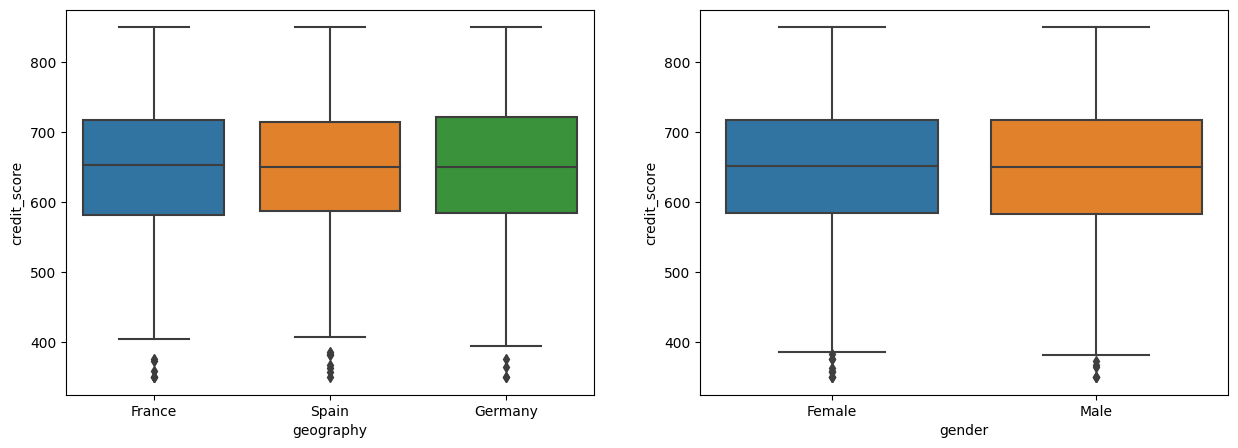

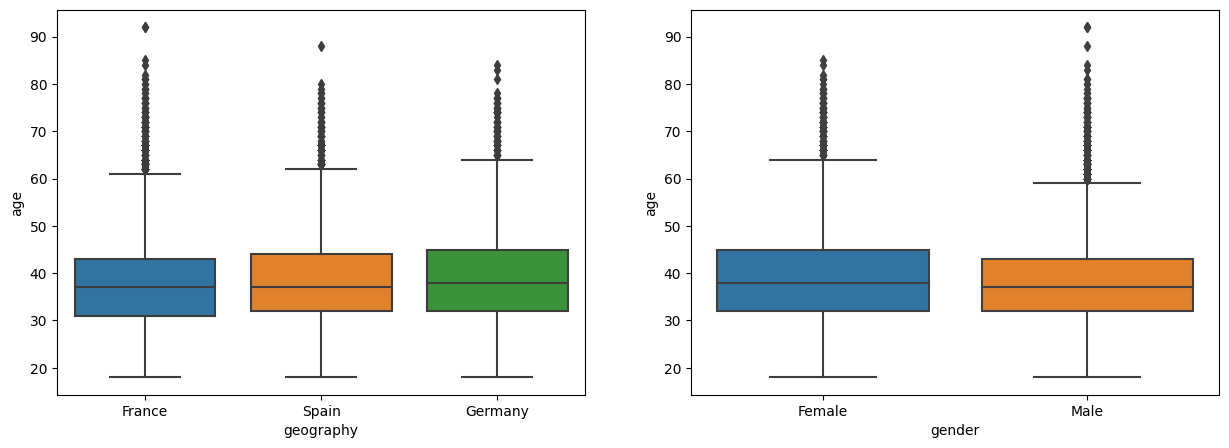

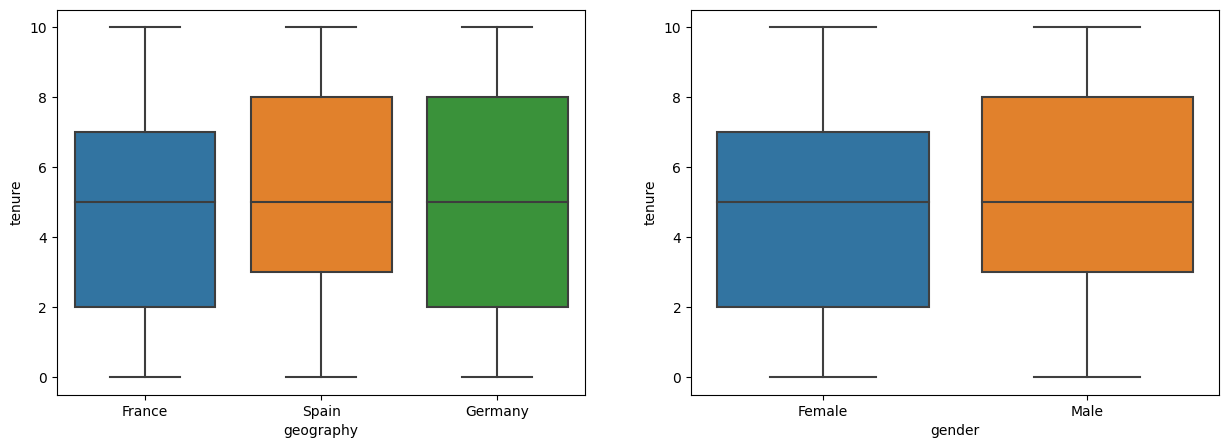

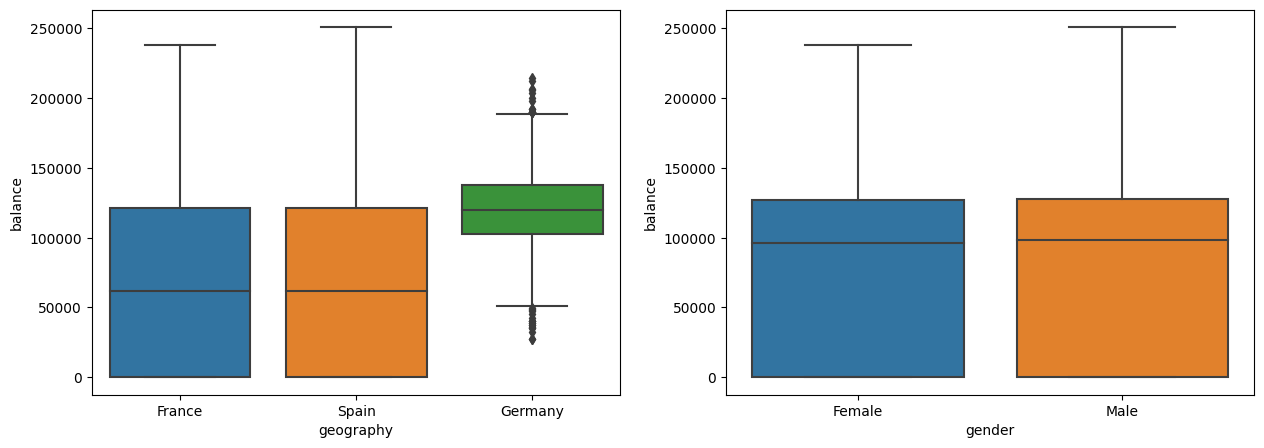

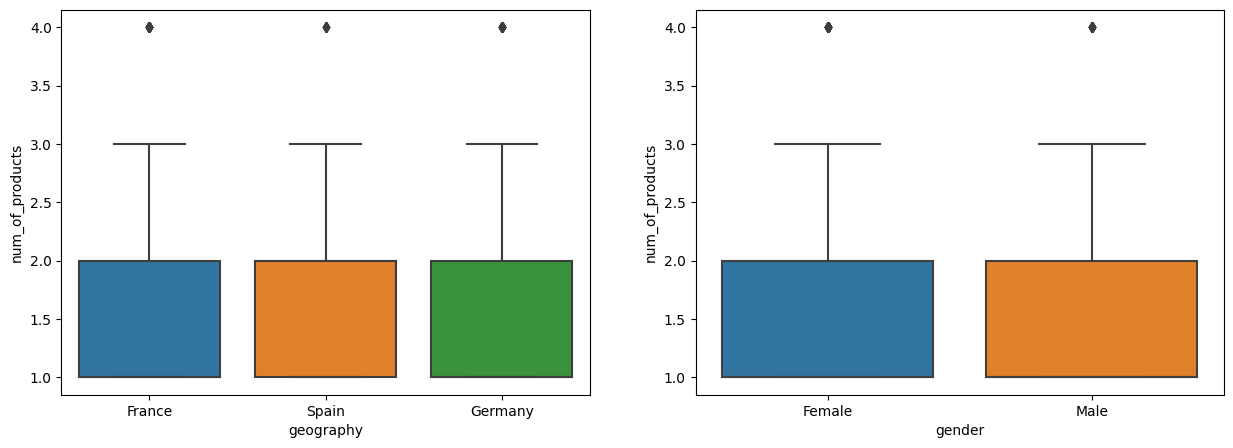

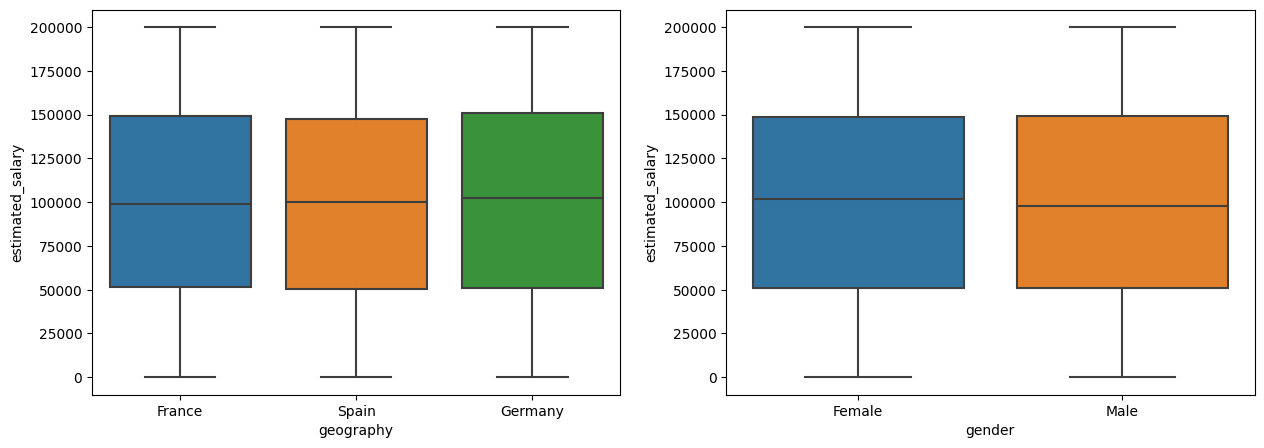

In [12]:
numerical_attributes_list = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

for attribute in numerical_attributes_list:
    plt.figure(figsize=(15,5))
    plt.subplot( 1, 2, 1 )
    sns.boxplot( x='geography', y = attribute, data=data )

    plt.subplot( 1, 2, 2 )
    sns.boxplot( x='gender', y = attribute, data=data )
    
    print("\n\n"); plt.show()

## 2.0 Hypotheses Creation

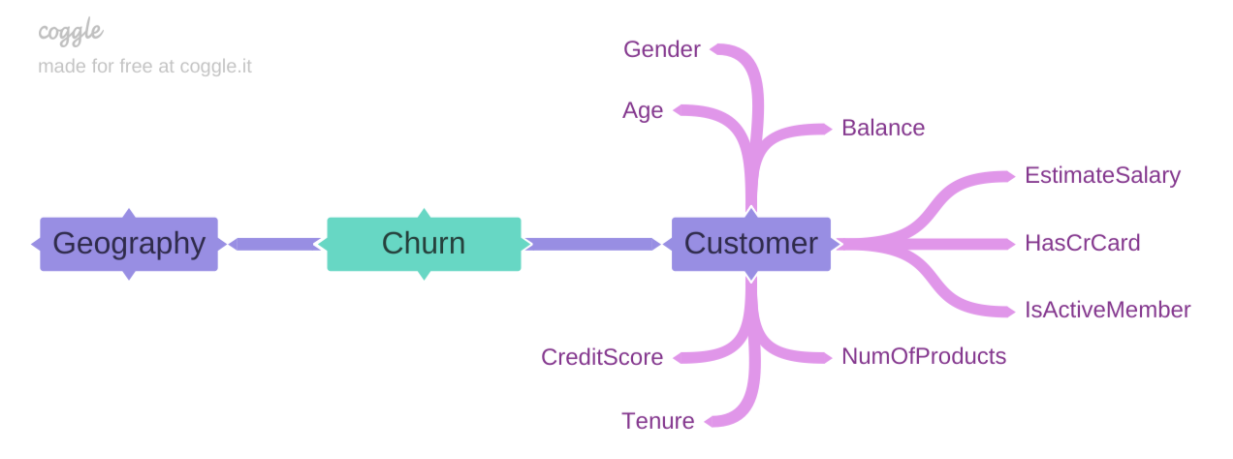

In [13]:
Image( '../images/hypotheses mind map.png' )

### 2.1 Hypotheses

#### 2.1.1. Customer hypotheses.

**1.** Younger customers have higher churn rate.
        
        Which age brings more revenue?

**2.** Higher balance customers have lower turnover rate.

        Does higher balance mean more revenue?

**3.** Customers with higer salaries have lower churn rate.

        Does higher salary mean more revenue?

**4.** Customers who are active members have lower churn rate.

        How much do we earn from active members?

**5.** Customers who buy more products have lower churn rate.

        Who brings us more revenue from those?

**6.** "Older" customers have lower churn rate.

        The longer the time, greater is the revenue?

**7.** Customers with credit card have a lower churn rate.

        Are they the most responsible for revenue?

**8.** Customers with higher credit score have lower churn rate.

        Does a higher credit score mean more revenue?

#### 2.1.3. Geography hypotheses.

        Which country does the biggest revenue come from?

**1.** Country that has more customers on "active members group" has lower churn rate.

**2.** Country with higher average credit score has lower churn rate.

**3.** Country with higher sum of balances have lower churn rate.

**4.** Country with higher average balance have lower churn rate.

**5.** Country with higher average salary has lower churn rate.

**6.** Country with more credit card customers has lower churn rate.

## 3.0 Feature Engineering

In [14]:
data.head(2)

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


### 3.1 Annual Revenue

    How much do TopBank expect to gain from this customer? 

**_According to the TopBank Analytics team, each customer who has this bank account returns a monetary value of 15% of the value of their estimated salary, if it is less than the average and 20% if this salary is higher than the average, during the current period of your account. This value is calculated annually._**

Let's calculate the annual revenue, then.

In [15]:
# symmetrical distribution - we'll use the mean
print( round(data['estimated_salary'].mean(),2), data['estimated_salary'].median() )

100090.24 100193.915


In [16]:
mean_salary = data['estimated_salary'].mean()
TWELVE_MONTHS = 12

data['annual_revenue'] = [(salary/TWELVE_MONTHS)*0.2 if salary > mean_salary else (salary/TWELVE_MONTHS)*0.15 
                           for salary in data['estimated_salary']]

### 3.2 Revenue per Product

    Would it be "How much is this customer paying for each product?"?
    Not quite, but since we don't have this specific data, let's use 
    it as an alternative.

In [17]:
data['revenue_per_product'] = data['annual_revenue'] / data['num_of_products']

### 3.3 Total Revenue

    How much did TopBank earn with this customer until today?

In [18]:
data['total_revenue'] = [tenure*annual_earning if tenure > 0 else annual_earning
                         for tenure, annual_earning in zip(data['tenure'], data['annual_revenue'])]

## 4.0 Filtering The Features

In [19]:
data_frame = data.copy()
data_frame.head(3)

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,annual_revenue,revenue_per_product,total_revenue
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1689.148000,1689.148000,3378.296000
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1875.709667,1875.709667,1875.709667
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1898.859500,632.953167,15190.876000


### 4.1 Column Selection

    These columns won't be helpful at all. They're too specific,
    We want to generalize so the solution will work for as much
    observations as we'll have.

In [20]:
drop_columns = ['row_number','customer_id','surname']
data_frame.drop(columns=drop_columns, inplace=True)

## 5.0 Exploratory Data Analysis

In [21]:
churn_data = data_frame.copy()

describe_data(churn_data)['data_types'].unique()

Shape: (10000, 14)
Duplicates: False


array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [22]:
numerical_attributes = churn_data.select_dtypes( include=['int64', 'float64'] )
categorical_attributes = churn_data.select_dtypes( exclude=['int64', 'float64'] )

### 5.1 Univariate Analysis

#### 5.1.1. Response Variable

> **_Imbalanced data. We'll have to deal with this later_**

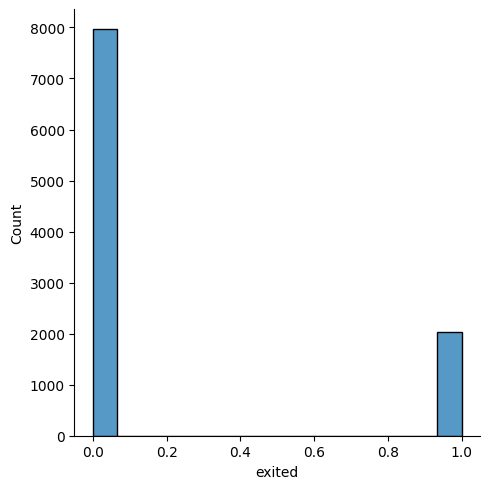

In [23]:
sns.displot(churn_data['exited'], kde=False);
plt.show()

#### 5.1.2. Numerical Variables

_Some assumptions we can't tell if they're true, but if we could, those would help us to understand better what's happening and how it affects the phenomenon._

> Credit Score

    The credit score distribution kind of tends to high values (the boxplot in 1.2.2.Categorical Attributes
    shows that too, but to really validate this We should talk to an expert from TopBank, then We could know
    exactly which value the company considers high). 
    
    50% of customers have a score above the mean, so when a customer leaves TopBank there's a good chance the
    company is losing a high quality customer.

> Tenure     

    "Tenures" are similar. If people are leaving at different times, it might be they're facing problems on 
    different services (we could also try to categorize by different types of customers... anyway, it's a
    whole new analysis), thus the enterprise would have to improve in more than just "some services"... As you
    can see, the histogram shows fewer people that churn in less than 1 year (0) and after 10 years (which doesn't
    make sense?), this probably happens because of the season the data started to be collected (mid-year, perhaps?)
    and when it was finally sent to analysis. Again, expertise domain from the company would really help (as well
    as more data representing other information, such as dates, products and so on).
    
> Balance 

    Similar assumption to Credit Score's. Losing a customer with high balance might be a situation we want to
    avoid. It's weird the fact that there're many accounts with 0 as balance.
    
> Number of Products

    Most of the customers consume 1 or 2 products. It would be good to ask the company which products are these
    to try to understand why this happens. Do people buy 1, 2 and then stop buying? Is it an aftersales problem?
    Or is is a normal phenomenon?
    
> Credit Card

    Most customers have credit card (70%). This can be good or bad, depending on how much the company wishes to gain
    from it (besides the "maximum gain" ideal) and depending on which metric they would use to measure that gain.
    But in general, it seems good.
    
    If customers with credit card bring higher revenue, there's also a high chance TopBank is losing good customers
    when they leave.
    
> Active Members
    
    We have an almost equal number of active and non-active members, not a very good sign if non-active members are
    the ones who leave the company in higher rates. We might want to investigate that later trying to understand why.
    
> Salary (annual_revenue, revenue_per_product, total_revenue)

    There is some quantity of salary with very low values... outliers, which affects features as
    annual_revenue, revenue_per_product and total_revenue. Those are basically telling us that most of 
    company's revenue comes from lower prices products (this might be a misinterpretation, though. Since
    we don't really know the actual prices for each product).

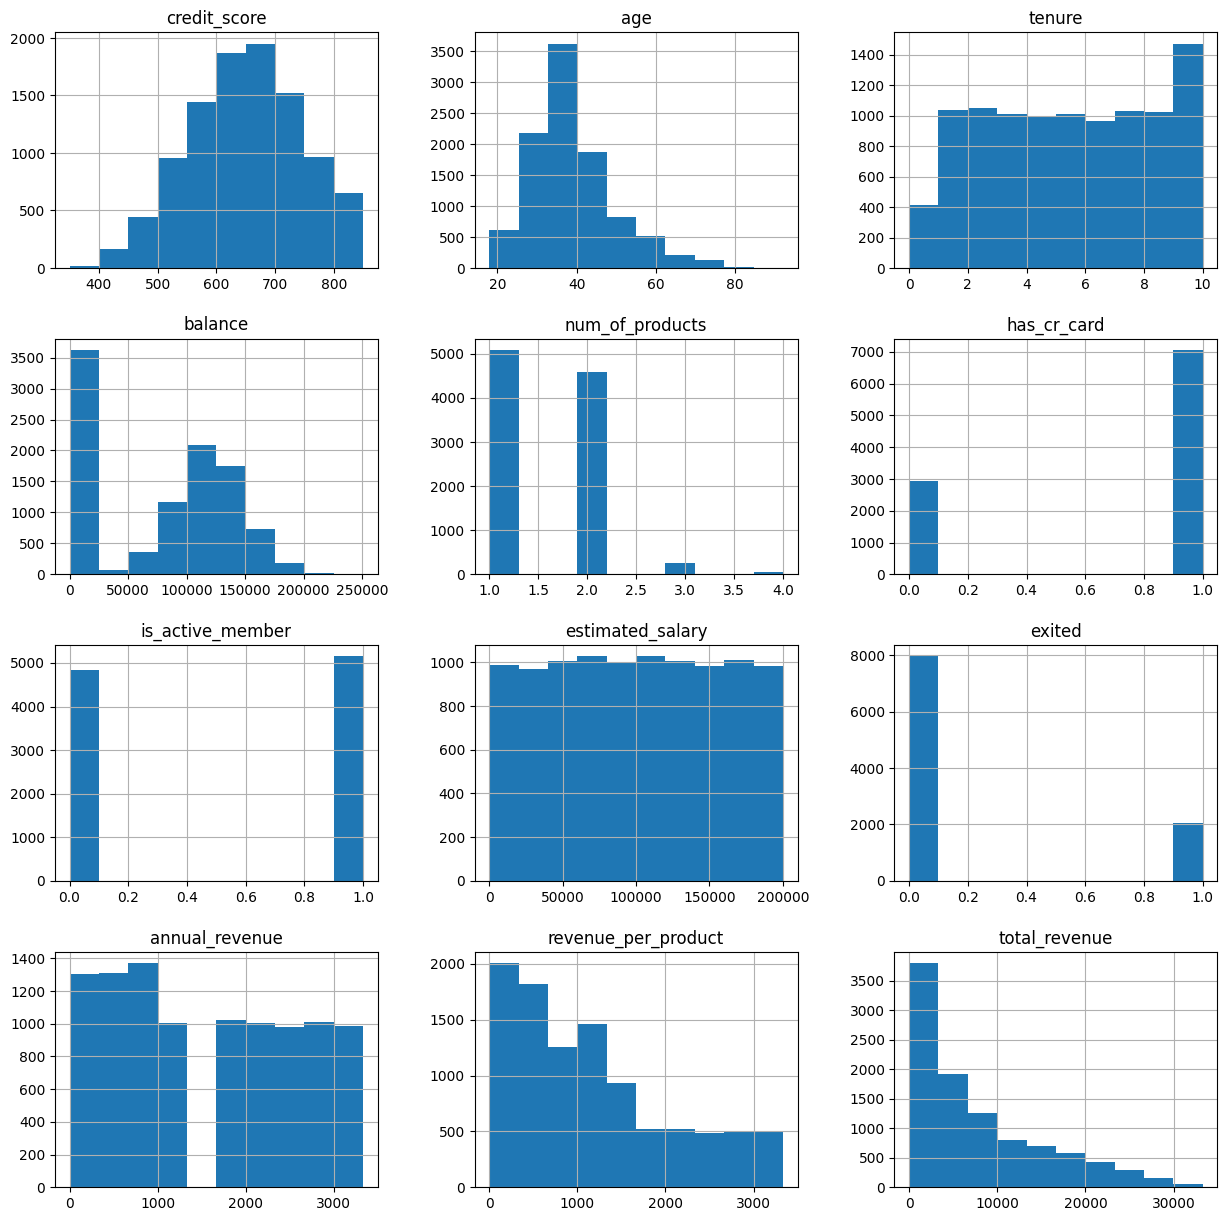

In [24]:
rows = int(np.ceil( numerical_attributes.shape[1]/3 ))
numerical_attributes.hist(figsize=(15,15), layout=(rows, 3));
plt.show()

In [25]:
total_customers = len(churn_data)

In [26]:
# Percentage of Credit score above the mean.
len(churn_data[churn_data.credit_score > churn_data.credit_score.mean()]) / total_customers

0.5063

In [27]:
# Percentage balance account above the median. I'm using the median because there are lots of accounts with 0 as balance.
# More of higher balances are good for the company, so we worry more about losing those, the median fits better, then.
len(churn_data[churn_data.balance > churn_data.balance.median()]) / total_customers

0.5

In [28]:
# Percentage of customers with credit card
len(churn_data[churn_data.has_cr_card == True]) / total_customers

0.7055

In [29]:
# Percentage of lower salary outliers
minimum_salary = 1000*12 # Spain has the minimum wage
len(churn_data[churn_data.estimated_salary < minimum_salary]) / total_customers

0.0598

In [30]:
churn_data = churn_data[churn_data['estimated_salary'] > minimum_salary]

#### 5.1.3. Categorical Variables

> Geography 

    France has twice as many customers as Germany. But Germany has twice the churn rate. This is kind of scary,
    but it may mean that TopBank should apply a different marketing plan there or those customers should receive 
    other services. As usual, communication with people with domain knowledge could guide our decisions here 
    (in case we decide to investigate deeper this event).
    
> Gender

    Even with more male data, it says females has the higher churn rates. 

In [31]:
get_categories(categorical_attributes)

,geography,gender
0,France,Female
1,Spain,Male
2,Germany,


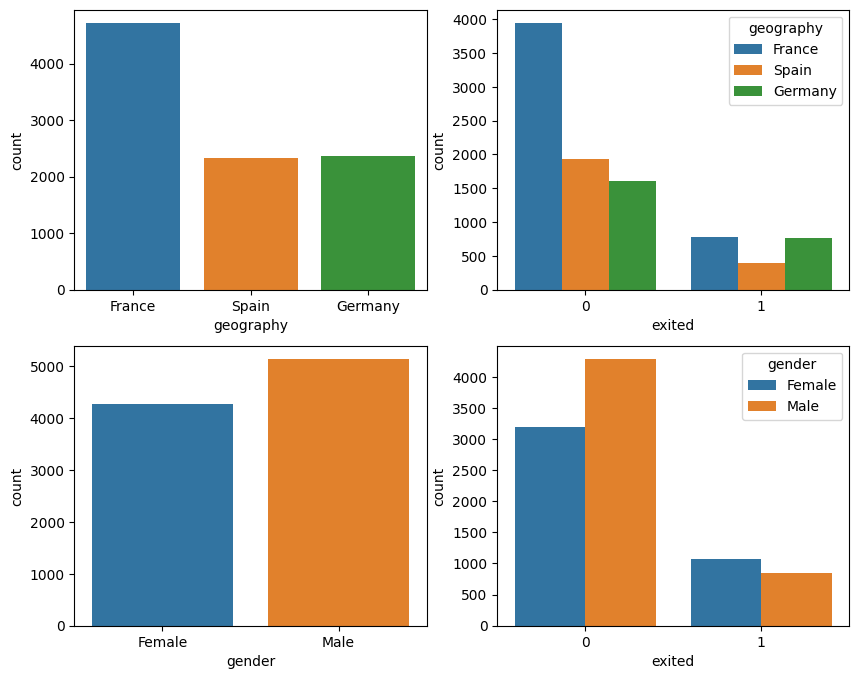

In [32]:
plt.figure(figsize=(10,8))

plt.subplot( 2, 2, 1 )
sns.countplot(x=churn_data['geography'])

plt.subplot( 2, 2, 2 )
sns.countplot(x='exited', hue='geography', data=churn_data)

plt.subplot( 2, 2, 3 )
sns.countplot(x=churn_data['gender'])

plt.subplot( 2, 2, 4 )
sns.countplot(x='exited', hue='gender', data=churn_data)

plt.show()

In [33]:
spain_data = churn_data[churn_data['geography'] == 'Spain']
france_data = churn_data[churn_data['geography'] == 'France']
germany_data = churn_data[churn_data['geography'] == 'Germany']

**_Churn Rate in each country_**

In [34]:
spain_churn = spain_data[spain_data['exited'] == True].shape[0] / spain_data.shape[0]
france_churn = france_data[france_data['exited'] == True].shape[0] / france_data.shape[0]
germany_churn = germany_data[germany_data['exited'] == True].shape[0] / germany_data.shape[0]

print(f"Spain    {round(spain_churn, 2)}.  Customers: {spain_data.shape[0]}")
print(f"France   {round(france_churn, 2)}.  Customers: {france_data.shape[0]}")
print(f"Germany  {round(germany_churn,2)}.  Customers: {germany_data.shape[0]}")

Spain    0.17.  Customers: 2327
France   0.16.  Customers: 4716
Germany  0.32.  Customers: 2359


In [35]:
female_1 = len(churn_data[(churn_data['gender'] == 'Female') & (churn_data['exited'] == True)])/total_customers
male_1 = len(churn_data[(churn_data['gender'] == 'Male') & (churn_data['exited'] == True)])/total_customers
print(f"Female Churn Rate: {female_1*100}%")
print(f"Male Churn Rate:   {male_1*100}%")
print()
female_1 = len(spain_data[(spain_data['gender'] == 'Female') & (spain_data['exited'] == True)])/ len(spain_data)
male_1 = len(spain_data[(spain_data['gender'] == 'Male') & (spain_data['exited'] == True)])/ len(spain_data)
print(f"Spain Female Churn Rate: {round(female_1*100, 2)}%")
print(f"Spain Male Churn Rate:   {round(male_1*100, 2)}%")
print()
female_1 = len(france_data[(france_data['gender'] == 'Female') & (france_data['exited'] == True)])/ len(france_data)
male_1 = len(france_data[(france_data['gender'] == 'Male') & (france_data['exited'] == True)])/ len(france_data)
print(f"France Female Churn Rate: {round(female_1*100, 2)}%")
print(f"France Male Churn Rate:   {round(male_1*100, 2)}%")
print()
female_1 = len(germany_data[(germany_data['gender'] == 'Female') & (germany_data['exited'] == True)])/ len(germany_data)
male_1 = len(germany_data[(germany_data['gender'] == 'Male') & (germany_data['exited'] == True)])/ len(germany_data)
print(f"Germany Female Churn Rate: {round(female_1*100, 2)}%")
print(f"Germany Male Churn Rate:   {round(male_1*100, 2)}%")

Female Churn Rate: 10.72%
Male Churn Rate:   8.51%

Spain Female Churn Rate: 9.5%
Spain Male Churn Rate:   7.26%

France Female Churn Rate: 9.27%
France Male Churn Rate:   7.17%

Germany Female Churn Rate: 17.55%
Germany Male Churn Rate:   14.58%


In [36]:
# Saving the progress
# churn_data.to_pickle("churn_data_EDA.pkl")
# churn_data = pd.read_pickle("churn_data_EDA.pkl")

### 5.2 Bivariate Analysis

### _Customer hypotheses._

In [37]:
df = churn_data.copy()

#### _1. Younger customers have higher churn rate._

> **No, most of churn rate comes from people of age between 38 - 52. <br>
> It means TopBank is losing people at their professional peak.** <br>
> And most of not churned customers are in between 28 - 42. Which make us think: <br>
> maybe TopBank should create new products/services... or adapt the existing ones <br>
> to better fit "older" customers.
    
**_Which age brings more revenue?_**

        40 years old - 744,891.15 EUR of annual revenue.
        37 years old - 734,320.97 EUR of annual revenue.
        38 years old - 713,875.61 EUR of annual revenue.

> Most revenue comes from customers of age between 29 - 43.   

In [38]:
# Ages with more Churned Customers
df.loc[df['exited'] == True ,'age'].value_counts().head(16).index.sort_values()

Int64Index([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52], dtype='int64')

In [39]:
# Ages with more Not Churned Customers
df.loc[df['exited'] == False ,'age'].value_counts().head(16).index.sort_values()

Int64Index([28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43], dtype='int64')

Categorizing age based on [career stage](https://www.amazingpeople.co.uk/career-stages/).

In [40]:
age_categories = pd.cut(churn_data['age'], range(18, 100, 7))
age_categories.name = 'age_stage'
df = pd.concat([df, age_categories], axis=1)

# asdasdasdasdasdasda
# asdasdasdasdasdasdaasdasdasdasdasdasdaasdasdasdasdasdasdaasdasdasdasdasdasdaasdasdasdasdasdasdaasdasdasdasdasdasdaasdasdasdasdasdasdaasdasdasdasdasdasda

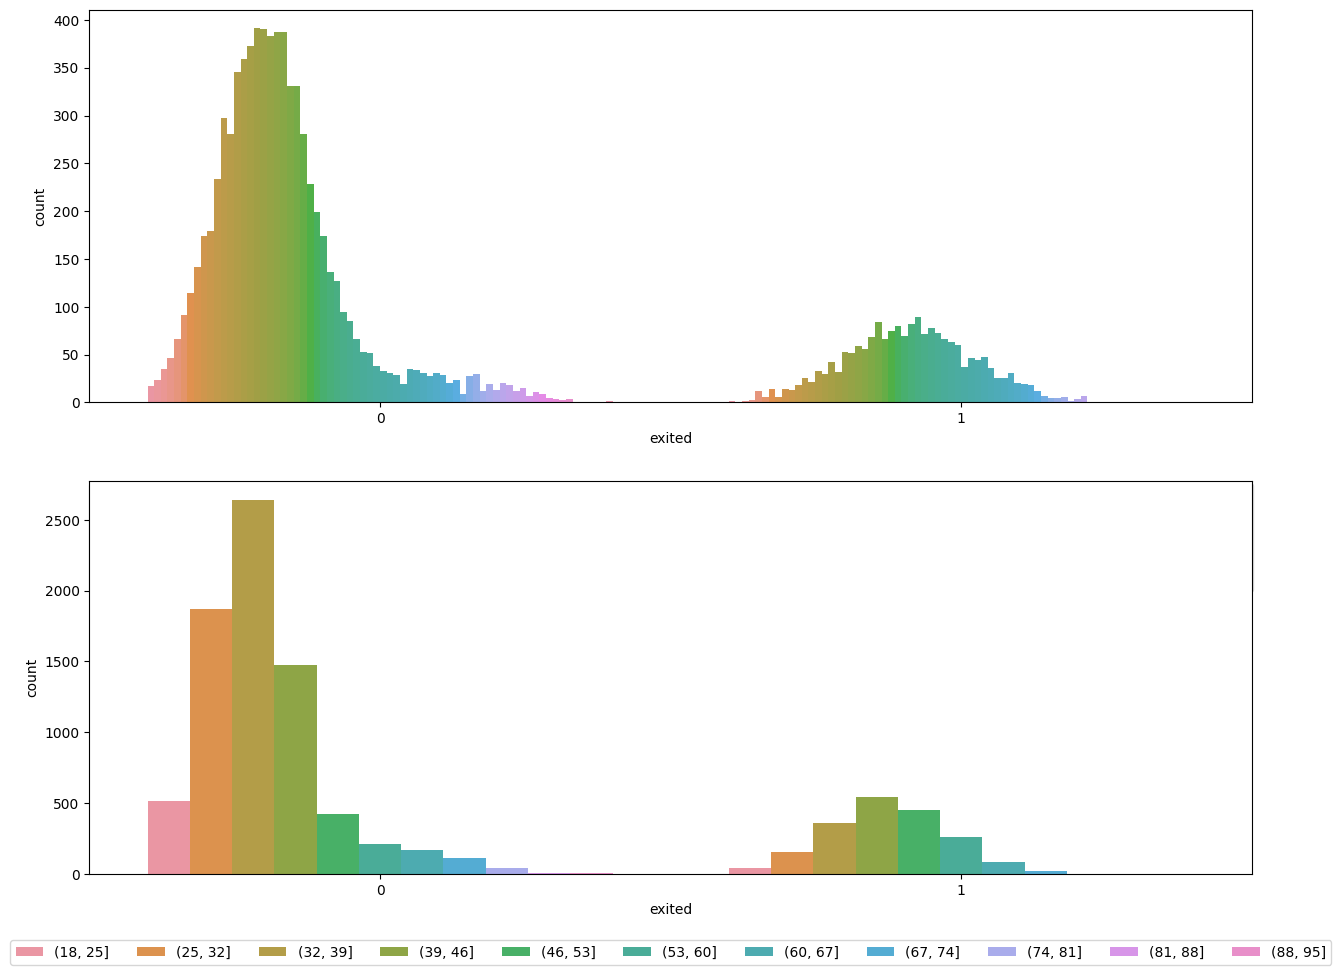

In [41]:
rows = 2; cols = 1
plt.figure(figsize=(15,8))
plt.subplot(rows, cols, 1)
sns.countplot( hue='age', x='exited', data=df)
plt.legend(loc = 'lower center', bbox_to_anchor=(0.5, -0.5), ncol=len(df.columns)-1)

plt.subplot(rows, cols, 2)
sns.countplot( hue='age_stage', x='exited', data=df)
plt.legend(loc = 'lower center', bbox_to_anchor=(0.5, -0.25), ncol=len(df.columns))

plt.subplots_adjust(bottom = -0.2)
plt.show()

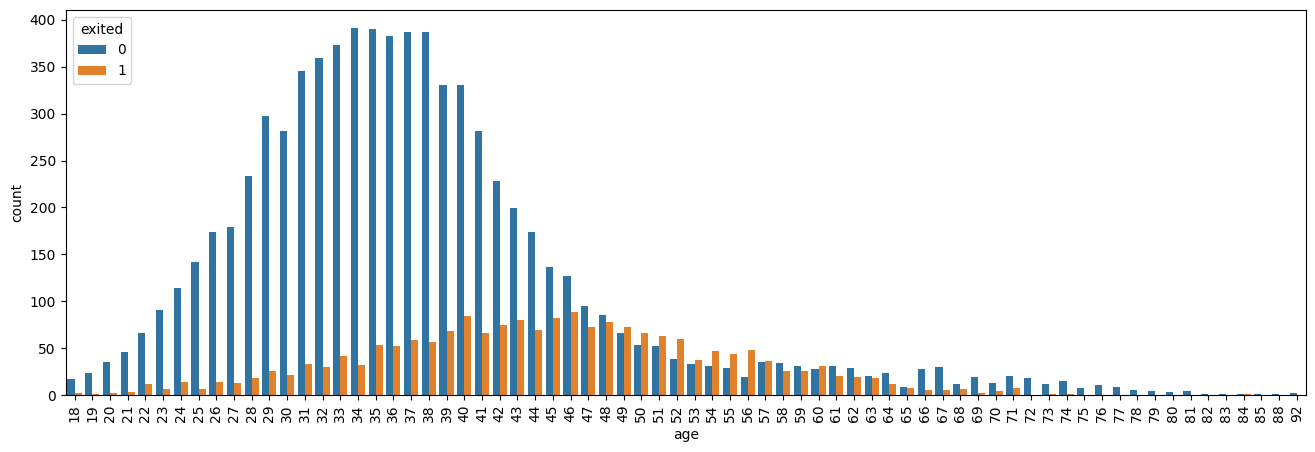

In [42]:
plt.figure(figsize=(16,5))
sns.countplot(x='age', hue='exited', data=df)
plt.xticks(rotation=90);
plt.show()

**_Which age brings more revenue?_**

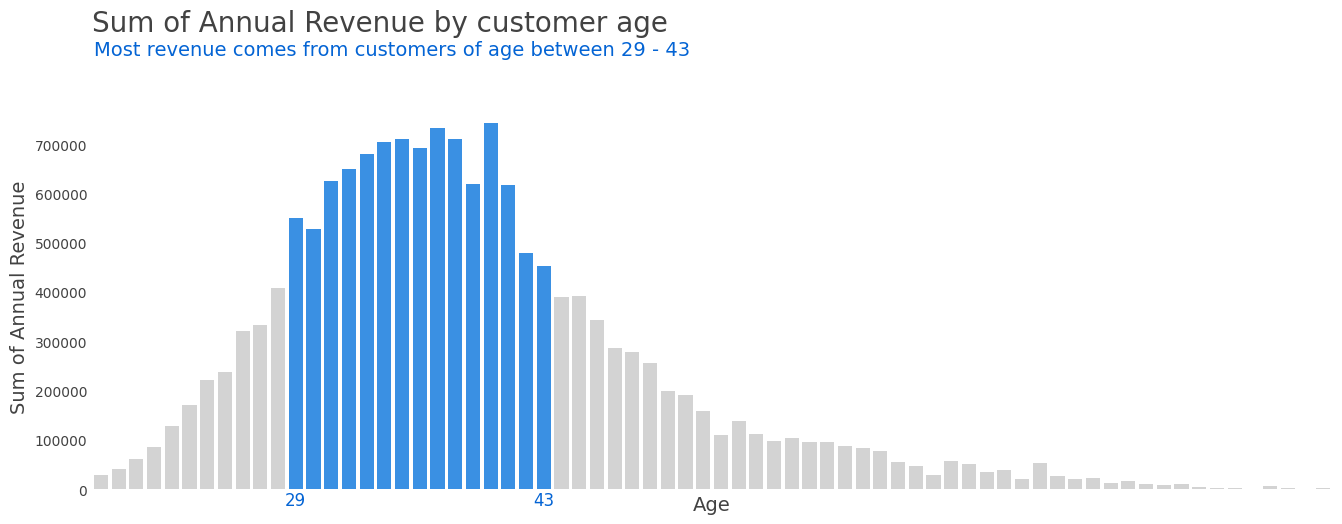

In [43]:
annual_revenue_per_age = df.groupby('age').sum()['annual_revenue']
colors = ['#D3D3D3' if age < 29 else
          '#D3D3D3' if age > 43 else
          'dodgerblue' for age in df.groupby('age').sum()['annual_revenue'].index]
plt.figure(figsize=(16,5))
sns.barplot( x=annual_revenue_per_age.index, y=annual_revenue_per_age, palette=colors);
plt.xlabel('Age', fontsize=14, color="#424242"); 
plt.ylabel('Sum of Annual Revenue', fontsize=14, color="#424242");
plt.box(False)
plt.title("Sum of Annual Revenue by customer age\n\n", color="#424242", loc='left', size=20)
plt.text(x=-0.4, y=880000, s="Most revenue comes from customers of age between 29 - 43", size=14, color='#0464d4')
plt.text(x=10.39, y=-32000, s="29", size=12, color='#0464d4')
plt.text(x=24.39, y=-32000, s="43", size=12, color='#0464d4')
plt.tick_params(axis='both', which='both', length=0)
plt.xticks([], rotation=0)
plt.yticks(color="#424242")
plt.show()

In [44]:
# Ages with greater sum of revenues
annual_revenue_per_age.round(2).sort_values(ascending=False).head(15).index.sort_values()

Int64Index([29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43], dtype='int64', name='age')

In [45]:
# 4.6% of revenue losses comes from Ages between [38 - 42]
exited_inner_most_revenue = [38, 39, 40 ,41 ,42, 43]
df[(df['exited'] == True) & (df['age'].isin(exited_inner_most_revenue))]['annual_revenue'].sum() / df['annual_revenue'].sum()

0.04615608867147897

In [46]:
pd.DataFrame( annual_revenue_per_age.round(2).sort_values(ascending=False).head() )

,annual_revenue
age,
40,743742.80
37,732260.17
38,711346.24
35,710036.70
34,703936.69


#### _2. Higher balance customers have lower turnover rate._
                
> Yes, but customers with lower balance also have lower churn rates, so it's not a trend, it's only a reflex of normal distributed data.


**_Does higher balance mean more revenue?_**

> No.


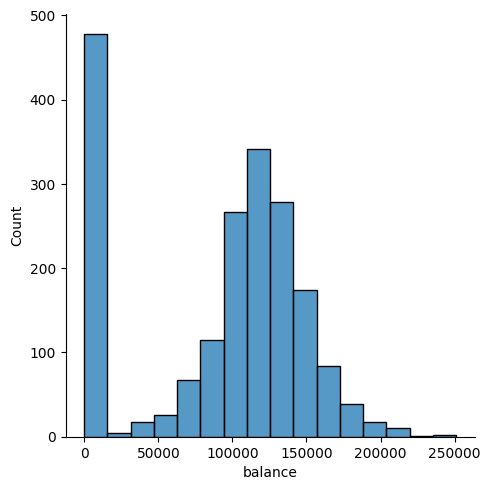

In [47]:
sns.displot(df.loc[ df['exited'] == True , 'balance'], kde=False);
plt.show()

In [48]:
print('Max Balance', df['balance'].max())

Max Balance 250898.09


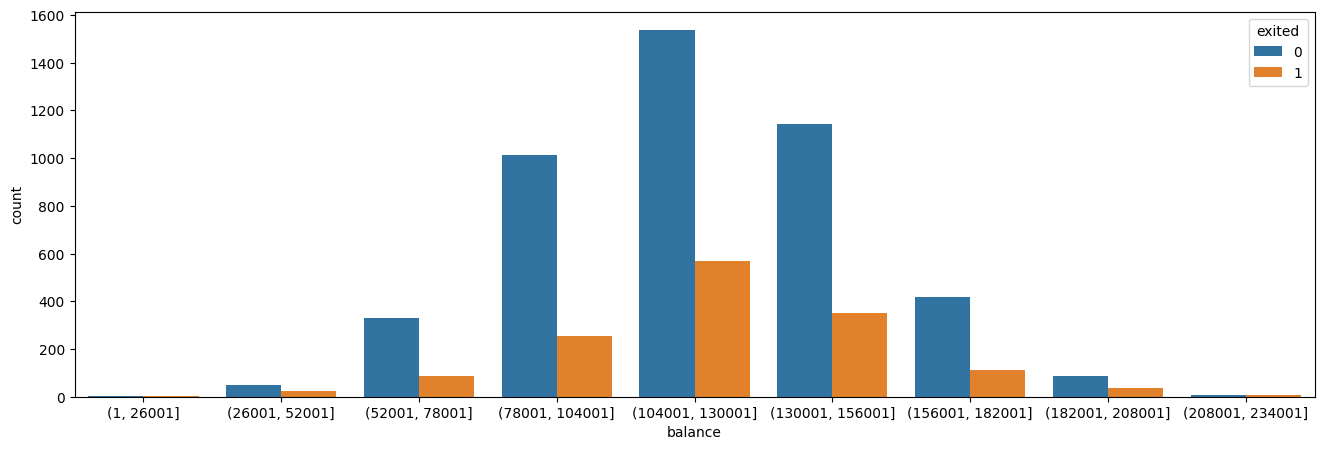

In [49]:
rounded_max_balance = 260000
ten_bins = int(rounded_max_balance/10)

balance_categories = pd.cut(churn_data['balance'], range(1, rounded_max_balance, ten_bins))

plt.figure(figsize=(16,5))
sns.countplot(x=balance_categories, hue=df.exited);
plt.show()

**_Does higher balance mean more revenue?_**

They're not [correlated](https://en.wikipedia.org/wiki/Correlation_and_dependence), so, no.

In [50]:
pd.concat([df.balance, df.annual_revenue, df.total_revenue], axis=1).corr().sample()

,balance,annual_revenue,total_revenue
total_revenue,-0.004725,0.674969,1.0


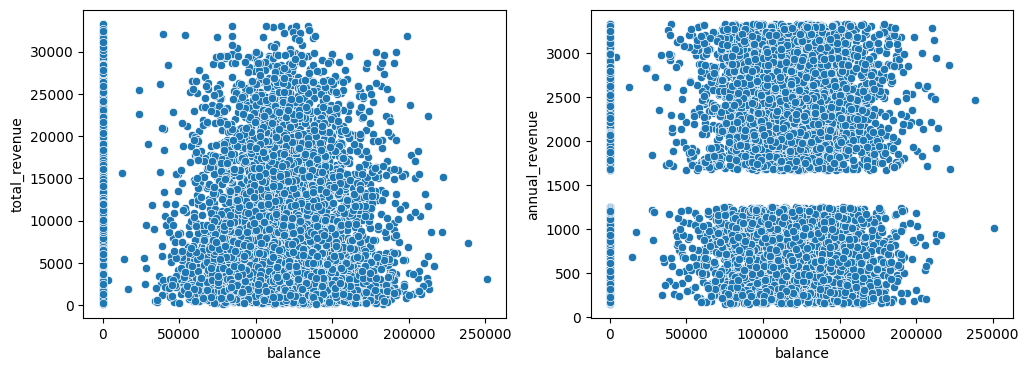

In [51]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='balance', y='total_revenue')
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='balance', y='annual_revenue')
plt.show()

#### _3. Customers with higer salaries have lower churn rate.._
                
> No, customers with higher salaries (above the mean) have a greater churn rate. However, <br>
> the difference is so low that It probably won't really affect our decisions, since the data <br>
> is kind of well distributed, so again, it doesn't mean that's a trend. I'd be just a coincidence.

**_Does higher salary mean more revenue?_**

> **Yes! Greater salary means more revenue.** <br>

    If there was a trend showing us that customers with 
    greater salaries were churning, we should be afraid,
    because that would mean the company would be losing 
    much more money.

In [52]:
# Churn Rate from people with salaries greater than the mean salary
len(df.loc[ (df['exited'] == True) & (df['estimated_salary'] > df['estimated_salary'].mean()), 'estimated_salary'])/ len(df)

0.10508402467560093

In [53]:
# Churn Rate from people with salaries lower than the mean salary
len(df.loc[ (df['exited'] == True) & (df['estimated_salary'] <= df['estimated_salary'].mean()), 'estimated_salary'])/ len(df)

0.09944692618591788

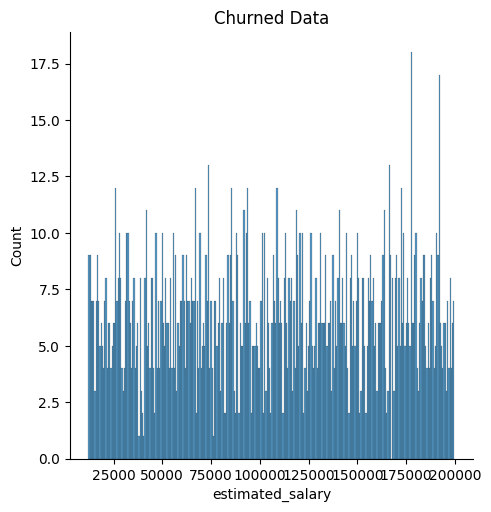

In [54]:
sns.displot(df.loc[ df['exited'] == True , 'estimated_salary'], kde=False, bins=300)
plt.title('Churned Data')
plt.show()

In [55]:
print('Max Salary', df['estimated_salary'].max())

Max Salary 199992.48


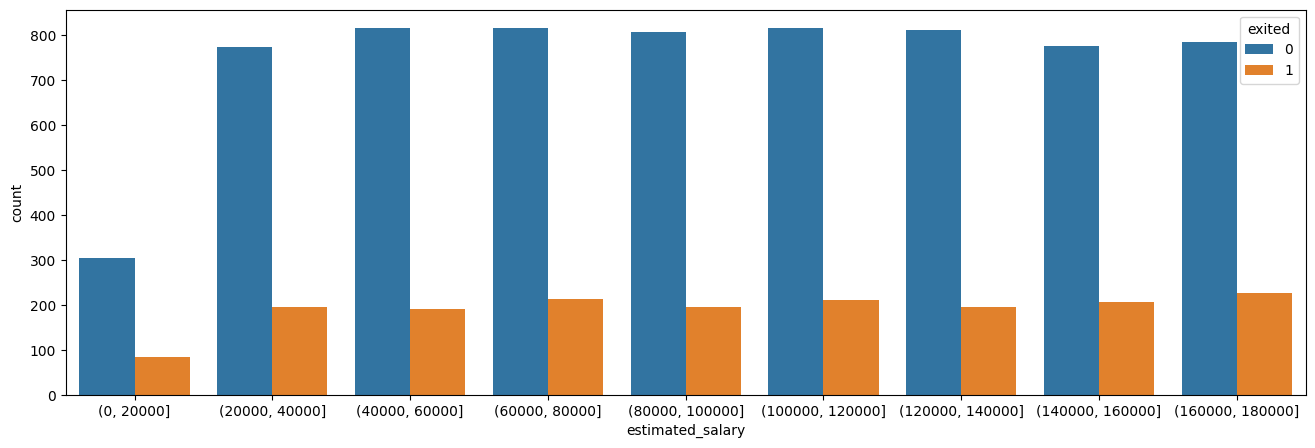

In [56]:
rounded_max_salary = 200000
ten_bins = int(rounded_max_salary/10)

salary_categories = pd.cut(churn_data['estimated_salary'], range(0, rounded_max_salary, ten_bins))

plt.figure(figsize=(16,5))
sns.countplot(x=salary_categories, hue=df.exited);
plt.show()

**_Does higher salary mean more revenue?_**

In [57]:
# HUMMM let's see what's happening here
pd.concat([df.estimated_salary, df.total_revenue], axis=1).corr()

,estimated_salary,total_revenue
estimated_salary,1.000000,0.670467
total_revenue,0.670467,1.000000


        Note that the tenure (how many years the customer was active before has churned)
        is a decisive fact here, because it's natural that the more years, the greater the 
        gain tends to be, since it's accumulative.

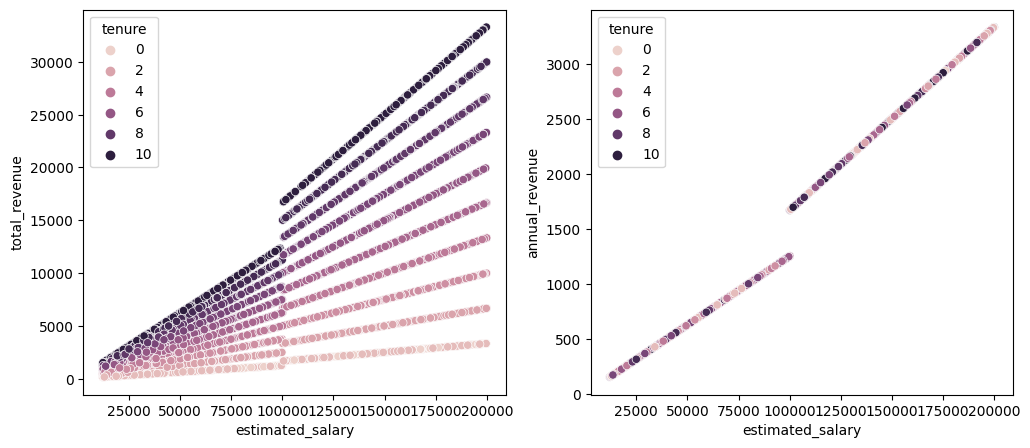

In [58]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(x = 'estimated_salary', y='total_revenue', hue='tenure', data=df);
plt.subplot(1,2,2)
sns.scatterplot(x = 'estimated_salary', y='annual_revenue', hue='tenure', data=df)
plt.show()

#### _4. Customers who are active members have lower churn rate._
                
> **Yes!** 7% against 13%
>
> **A good reason to try to make customers active members. Besides, <br>
> those who are from active members group have a churn rate of 14%. <br>
> That means 14% of active members may churn, while for inactive group <br>
> that value grows to 27%.**

**_How much do TopBank earn from active members?_**

> It's expected for TopBank to earn about 1,550.00 EUR annually for each active member <br>
> **with 55% of revenue coming from active members.**

In [59]:
# Churn Rate by "activiness"
pd.DataFrame( df.groupby('is_active_member').sum().exited/ len(df) )

,exited
is_active_member,
0,0.130291
1,0.074240


        From Active and Inactive Groups
          Active Members Churn:    14.41%
          Inactive Members Churn:  26.86%

In [60]:
# Churn Rate inside each activiness group (active and inactive members)
pd.DataFrame( df.groupby('is_active_member').mean().exited )

,exited
is_active_member,
0,0.268699
1,0.144126


**_How much do we earn from active members?_**

In [62]:
# Usual annual revenue per active and inactive members
df.groupby('is_active_member').mean().annual_revenue.round(2) 

is_active_member
0    1669.84
1    1647.29
Name: annual_revenue, dtype: float64

In [74]:
# Percentage of active members 
(df.groupby('is_active_member').count().annual_revenue[1]) / len(df)
# df['is_active_member'].value_counts(normalize=True)

0.5151031695383961

In [64]:
# Percentage of active members REVENUE 
(df.groupby('is_active_member').sum().annual_revenue.round(2)[1]) / df.annual_revenue.sum()

0.5117075616944781

        Let's calculate for considering only not churned customers, so we can know the effective gains.

In [81]:
aux = df[df['exited'] == False]
aux.groupby('is_active_member').mean().annual_revenue.round(2) 

is_active_member
0    1662.05
1    1645.46
Name: annual_revenue, dtype: float64

In [82]:
# Percentage of active members that hasn't churned
(aux.groupby('is_active_member').count().annual_revenue.round(2)[1]) / len(aux)

0.5542184784062041

In [83]:
# Percentage of inactive members that hasn't churned
(aux.groupby('is_active_member').count().annual_revenue.round(2)[0])  / len(aux)

0.44578152159379597

In [84]:
# Percentage of active members REVENUE that did not churn
(aux.groupby('is_active_member').sum().annual_revenue.round(2)[1]) / aux.annual_revenue.sum()

0.5517382044706981

In [85]:
# Percentage of active members REVENUE that did churn
(aux.groupby('is_active_member').sum().annual_revenue.round(2)[0]) / aux.annual_revenue.sum()

0.44826179589332876

In [95]:
# df.groupby("tenure").exited.agg(["count", "mean"]).sort_values("mean")

#### _5. Customers who buy more products have lower churn rate._
                
> False.

        Number of Products    Churn Rate
                1                 27%
                2                  7%
                3                 83%
                4                100%
              
                
<br> 

**_Who brings us more revenue from those?_**

        Number of Products    Mean Revenue
                1               1644.86
                2               1667.47
                3               1735.27
                4               1745.93

> The more the products the more the mean revenue.

In [141]:
# Churn Rate by "number of product" category
aux = pd.DataFrame( df.groupby('num_of_products').exited.agg(['count', 'sum', 'mean']) )
aux.columns = ['Customers Quantity', 'Churned Customer', 'Churn Rate (%)']
aux = aux[['Churn Rate (%)', 'Churned Customer', 'Customers Quantity']]
aux['Churn Rate (%)'] = aux['Churn Rate (%)']* 100
aux

,Churn Rate (%),Churned Customer,Customers Quantity
num_of_products,,,
1,27.732497,1327,4785
2,7.722635,333,4312
3,83.064516,206,248
4,100.000000,57,57


**_Who brings us more revenue from those?_**

        The more the products the more the mean revenue.

In [142]:
aux2 = pd.DataFrame( df.groupby('num_of_products').annual_revenue.agg(['sum', 'mean']) ).round(2)
aux2.columns = ['sum', 'Average Revenue']
aux2

,sum,Average Revenue
num_of_products,,
1,7870633.07,1644.86
2,7190126.39,1667.47
3,430345.91,1735.27
4,99518.12,1745.93


In [143]:
aux = pd.concat([aux, aux2['Average Revenue']], axis=1)

In [150]:
def style_specific_cell(x):
    df = pd.DataFrame('', index=x.index, columns=x.columns)
    df.iloc[0:, 0] = 'background-color: lightblue'
    df.iloc[0:, 1] = 'background-color: lightgreen'
    df.iloc[0:, 2:] = 'color: #606060'

    return df
cols = ['Churn Rate (%)', 'Average Revenue', 'Churned Customer', 'Customers Quantity']
aux[cols].style.apply(style_specific_cell, axis=None).format("{:.2f}")

,Churn Rate (%),Average Revenue,Churned Customer,Customers Quantity
num_of_products,,,,
1,27.73,1644.86,1327.00,4785.00
2,7.72,1667.47,333.00,4312.00
3,83.06,1735.27,206.00,248.00
4,100.00,1745.93,57.00,57.00


#### _6. "Older" customers have lower churn rate._
                
> Yes. The sum, mean and median of churn rates from higher <br>
> tenures are lower than the churn rates from lower tenures.

**_The longer that time, greater is the revenue?_**

> **No, The annual gains are pretty similar, <br>
> so in the long term, yes, the accumulated value <br>
> increases, but that doesn't mean the customer <br>
> buys more products or spends more money on <br>
> the company.**

In [ ]:
# The mean tells us the churn rate into each group so let's use it.
churn_by_tenure = df.groupby("tenure").exited.describe()
churn_by_tenure

In [ ]:
plt.figure(figsize=(16,5))
sns.lineplot( x=churn_by_tenure.index , y=churn_by_tenure['mean'] );
plt.xticks(churn_by_tenure.index);
plt.show()

In [ ]:
def get_members_churn(data, is_active):
    member_churn = {
        'tenure': [],
        'total_customers': [],
        'churned_customers': [],
        'churn_rate': []
    }

    for tenure in data['tenure'].unique():
        churned_data = data[data['tenure'] == tenure]

        total_customers = len(churned_data)
        churned_customers = len(churned_data[(churned_data['exited'] == True) & (churned_data['is_active_member']==is_active)])
        churn_rate = churned_customers/total_customers

        member_churn['tenure'].append(tenure)
        member_churn['total_customers'].append(total_customers)
        member_churn['churned_customers'].append(churned_customers)
        member_churn['churn_rate'].append(churn_rate)
    
    return pd.DataFrame(member_churn)

In [ ]:
active_member_churn = get_members_churn(churn_data, is_active=True)
inactive_member_churn = get_members_churn(churn_data, is_active=False)

**Inactive Customers have higher churn rate.**

In [ ]:
plt.figure(figsize=(14,5))
sns.lineplot(x=churn_by_tenure.index, y=churn_by_tenure['mean']*100, label='Churn Rate', marker='o')
sns.lineplot(x=churn_by_tenure.index, y=inactive_member_churn['churn_rate']*100, label='Inactive Members Churn', marker='o')
sns.lineplot(x=churn_by_tenure.index, y=active_member_churn['churn_rate']*100, label='Active Members Churn', marker='o')
plt.legend(bbox_to_anchor=(1, 1.03), frameon=False)
plt.xticks(churn_by_tenure.index, color="#424242");
plt.title("Churn Rate by years customers have been clients\n", size=20, color="#424242");  
plt.xlabel("Tenure (years customers have been clients)", size=14, color="#424242");
plt.ylabel("Churn Rate(%)", size=14, color="#424242")
plt.tick_params(axis='both', which='both', length=0)
plt.grid(axis="x", linewidth=.2)
plt.box(False)
plt.show()

The sum, mean and median of churn rates from higher tenures are lower than the churn rates from lower tenures.

In [ ]:
print( churn_by_tenure.loc[churn_by_tenure.index >= 5, 'mean'].sum() )
print( churn_by_tenure.loc[churn_by_tenure.index >= 5, 'mean'].mean() )
print( churn_by_tenure.loc[churn_by_tenure.index >= 5, 'mean'].median() )

In [ ]:
print( churn_by_tenure.loc[churn_by_tenure.index <= 5, 'mean'].sum() )
print( churn_by_tenure.loc[churn_by_tenure.index <= 5, 'mean'].mean() )
print( churn_by_tenure.loc[churn_by_tenure.index <= 5, 'mean'].median() )

    Average churn rates according to tenures
    
      General Churn Rate:        20.51%
          Active Members Churn:    7.51%
          Inactive Members Churn:  12.99%

In [ ]:
churn_by_tenure['mean'].mean() * 100

In [ ]:
active_member_churn['churn_rate'].mean() * 100

In [ ]:
inactive_member_churn['churn_rate'].mean() * 100

**_The longer that time, greater is the revenue?_**

In [ ]:
total_revenue_by_tenure = df.groupby("tenure").total_revenue.sum().round(2)
sns.barplot(x=total_revenue_by_tenure.index, y=total_revenue_by_tenure, palette='Blues');
plt.show()

In [ ]:
annual_revenue_by_tenure = df.groupby("tenure").annual_revenue.sum().round(2)
sns.barplot(x=annual_revenue_by_tenure.index, y=annual_revenue_by_tenure, color='#');
plt.show()

    Greater values came from 7, 1, 8, 2... big tenure, small tenure, big tenure, small tenure... not really a time relation


In [ ]:
annual_revenue_by_tenure.sort_values(ascending=False)

#### _7. Customers with credit card have a lower churn rate._
                
> No, **the rates within the groups are quite equals  <br>
> and also, as there are more customers with credit card, that is a bad sign<br>
> because it means TopBank is losing many good customers.**

**_Are they the most responsible for revenue?_**

        "Most of customers have credit card, and if customers with credit card bring higher 
         revenue also there's a high chance we're losing a good customers when they churn".

> Yes, but again, **imbalance in data, 70% of customers has credit card. So, <br>
> after dealing with that, it seems that customers with no credit card are <br>
> the responsible ones.**

In [151]:
df.groupby("has_cr_card").exited.describe()

,count,mean,std,min,25%,50%,75%,max
has_cr_card,,,,,,,,
0,2742.0,0.207513,0.405600,0.0,0.0,0.0,0.0,1.0
1,6660.0,0.203303,0.402487,0.0,0.0,0.0,0.0,1.0


In [152]:
# Churned customers without credit card
len(df[(df['has_cr_card'] == False) & (df['exited'] == True)])

569

In [153]:
# Churned customers with credit card
len(df[(df['has_cr_card'] == True) & (df['exited'] == True)])

1354

In [154]:
print('  General Churn Rate')
print(f"No Credit Card {613/10000}")
print(f"Credit Card    {1424/10000}")

  General Churn Rate
No Credit Card 0.0613
Credit Card    0.1424


In [155]:
print('  Categorical Churn Rate')
print(f"No Credit Card {613/2945}")
print(f"Credit Card    {1424/7055}")

  Categorical Churn Rate
No Credit Card 0.20814940577249574
Credit Card    0.20184266477675408


**_Are they the most responsible for revenue?_**

In [ ]:
df.groupby("has_cr_card").annual_revenue.sum().round(2)

In [ ]:
df.groupby("has_cr_card").total_revenue.sum().round(2)

In [ ]:
df.groupby("has_cr_card").annual_revenue.describe().round(2)

In [ ]:
customer_quantity = 5000

In [ ]:
# No Credit Card
print("Rescaled value by:\n    mean        median")
print(f"{customer_quantity * 1580.17}   {customer_quantity * 1693.62}")

In [ ]:
# Credit Card
print("Rescaled value by:\n    mean        median")
print(f"{customer_quantity * 1556.45}    {customer_quantity * 1242.48}")

#### _8. Customers with higher credit score have lower churn rate._
                
> Yes, though it's a tiny difference.

**_Does a higher credit score mean more revenue?_**

> No, it doesn't.

In [ ]:
df['credit_score'].hist();

In [ ]:
# Churn Rate for Credit Score above the mean
df.loc[df['credit_score'] > df['credit_score'].median(), 'exited'].sum() / len(df)

In [ ]:
# Churn Rate for Credit Score below the mean
df.loc[df['credit_score'] < df['credit_score'].median(), 'exited'].sum() / len(df)

**_Does a higher credit score mean more revenue?_**

        Nope, if that so, we would see the color getting darker from left to right.

In [ ]:
plt.title(t, color="#424242", loc='left', size=16)
plt.xticks(rotation=0)
plt.yticks(color="#424242")
plt.xlabel("Age", color='#424242', size=14)
plt.ylabel("Quantity", color='#424242', size=14)
plt.legend(["Not Churned","Churned"], frameon=False, loc=9)

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='credit_score', y='total_revenue', hue='annual_revenue', data=df);
plt.tick_params(axis='both', which='both', length=0)
plt.ylabel("Cumulative Revenue", color='#424242', size=14)
plt.xlabel("Credit Score", color='#424242', size=14)
plt.box(False)

plt.subplot(1, 2, 2)
sns.scatterplot(x='credit_score', y='total_revenue', hue='exited', data=df);
plt.tick_params(axis='both', which='both', length=0)
plt.box(False)
plt.legend(["Churn", "Not Churn"],frameon=False)
plt.ylabel("Cumulative Revenue", color='#424242', size=14)
plt.xlabel("Credit Score", color='#424242', size=14)

plt.show()

In [ ]:
cut_credit_score = pd.Series(pd.cut(df['credit_score'], 10), name='credit_score_category')
df = pd.concat([df, cut_credit_score], axis=1)

In [ ]:
plt.figure(figsize=(16,5))
sns.barplot(x='credit_score_category', y='annual_revenue', data=df);
plt.show()

In [ ]:
plt.figure(figsize=(16,5))
sns.barplot(x='credit_score_category', y='total_revenue', data=df);
plt.show()

In [ ]:
df.groupby('credit_score_category').annual_revenue.describe()

In [ ]:
# mean and median

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
(df.groupby('credit_score_category').annual_revenue.mean()).plot()
plt.subplot(1, 2, 2)
(df.groupby('credit_score_category').annual_revenue.median()).plot()
plt.show()

### _Geography hypotheses._

    Which country does the biggest revenue come from?
    
> France, and one more time: imbalanced data, half of customers are located there. <br>
> **Balancing the data, Germany seems to be the right place to invest on.** Even because <br>
> (as we've seen before) there are high quality customers churning from there.


In [ ]:
df.groupby('geography').annual_revenue.sum().round(2)

In [ ]:
df.groupby('geography').annual_revenue.describe().round(2)

In [ ]:
(df.groupby('geography').annual_revenue.describe()[['mean','50%']]*5000).round(2)

#### _1. Country that has more customers on "active members group" has lower churn rate._
                
> Yes. Not in a general churn rate calculus, but looking at regions <br>
> as individual environments, France has lower churn rate, followed <br>
> by Spain and then Germany. However, the difference is not large <br>
> enough for us to make affirmations.
>
> We can see, though... that active customers have lower churn rate. <br>
> So, **action plans that focus on making the customers more active may <br>
> bring good results.**

In [ ]:
# Does France has lower churn rate? Let's check!
customers_quantity = pd.Series( df.groupby(['geography']).is_active_member.count(), name='customers_quantity' )
active_quantity =  pd.Series( df.groupby(['geography']).is_active_member.sum(), name='active_quantity' )
churned_quantity =  pd.Series( df.groupby(['geography']).exited.sum(), name='churned_quantity' )
general_churn = pd.Series( df.groupby(['geography']).exited.sum() / len(df), name='general_churn' )
churn_into = pd.Series( df.groupby(['geography']).exited.mean(), name='churn_into_country' )

country_churn = pd.concat([customers_quantity, active_quantity, churned_quantity, general_churn, churn_into], axis=1)
country_churn

In [ ]:
# Germany churn rates keeps insane...
pd.DataFrame( df.groupby(['geography','is_active_member']).exited.mean()*100 ).round(2)

#### _2. Country with higher average credit score has lower churn rate._
                
> Negative! Germany has the higher churn rate, mainly if we <br>
> look at it as an individual environment.

In [ ]:
df.groupby(['geography']).credit_score.mean()

#### _3. Country with higher sum of balances have lower churn rate._
                
> Yes.

In [ ]:
df.groupby(['geography']).balance.sum().round(1)

#### _4. Country with higher average balance have lower churn rate._
                
> False.

In [ ]:
df.groupby(['geography']).balance.mean()

#### _5. Country with higher average salary has lower churn rate._
                
> False

In [ ]:
df.groupby(['geography']).estimated_salary.mean()

Germany really seems to have high quality customers. So the fact that it has a churn rate too high is really sad. Probably We'll have to create a specific action plan for it.

#### _6. Country with more credit card customers has lower churn rate._
                
> True

        70% of customers has credit card even in each country.

In [ ]:
df.groupby(['geography']).has_cr_card.sum()

In [ ]:
df.groupby(['geography']).has_cr_card.sum() / country_churn['customers_quantity']

**Final thoughts: How much Money has TopBank lost?**

    Let's do a little experiment: We know the revenue TopBank gains each year. Then, let's consider 
    that this year We have only the customers who has not churned (no new customers, no new churned).
    How much money would we lose (knowing that we have the actual revenue for each customer)?

In [ ]:
# Not churned customers sum of revenues
gained_revenue = round( df.loc[ df['exited'] == False, 'annual_revenue'].sum(), 2)

# Churned customers sum of revenues
lost_revenue = round( df.loc[ df['exited'] == True, 'annual_revenue'].sum(), 2)

print(f"How much we really gained (7963 not churned customers): {gained_revenue}")
print(f"How much we have lost (2037 churned customers):          {lost_revenue}")

> **How much we really gained:** _12 million_ <br>
> **How much we have lost:** _3 million_


    Now, considering that same situation, but in a more... predictive approach. How much money would we lose?

In [ ]:
print('Not Churned quantity ', len(df.loc[ df['exited'] == False]))
print('Churned quantity     ', len(df.loc[ df['exited'] == True]))

In [ ]:
number_of_customers = len(df)

# Not churned customers sum of revenues
total_revenue = round(df.loc[ df['exited'] == False, 'annual_revenue'].sum(), 2)

# Mean revenue from Not churned customers
expected_revenue_per_customer = round( df.loc[ df['exited'] == False, 'annual_revenue'].mean(), 2)

# Revenue if we had 10,000 customers
expected_revenue = expected_revenue_per_customer * number_of_customers
print(f"How much we expected to gain (10,000 customers):   {expected_revenue}")

# Revenue from the actual 7,963 not churned customers
print(f"How much we really gained (7963 not churned):      {total_revenue}")

result = expected_revenue - total_revenue
print(f'How much we would lose (2037 churned customers):    {result.round(2)}')

Again, similar result, but this time we confirmed we would've gained about 16 million EUR.

> **How much we expected to gain:** _15.5 millions_ <br>
> **How much we really gained:**    _12 millions_ <br>
> **How much we have lost:**        _3 millions_ <br>

In [ ]:
# Saving the progress
# df.to_pickle("churn_data_Modeling.pkl")
# df = pd.read_pickle("churn_data_Modeling.pkl")

### 5.3 Multivariate Analysis

In [ ]:
numerical_attributes = churn_data.select_dtypes( include=['int64', 'float64'] )
categorical_attributes = churn_data.select_dtypes( exclude=['int64', 'float64'] )

#### 5.3.1. Numerical Attributes

In [ ]:
# plt.figure(figsize=(15, 6))
# sns.heatmap(numerical_attributes.corr().round(3), annot=True )
# plt.show()

plt.figure(figsize=(24, 12))
correlations = numerical_attributes.corr().round(2)
mask = np.triu(np.ones_like(correlations, dtype=np.bool))
sns.heatmap(correlations, mask=mask, linewidths=1, annot=True, cmap=['#F2F2F0','#1F375D'], vmin=0.40) #vmax=-0.40
plt.show()

#### 5.3.2. Categorical Attributes

[Cramer's v](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V)

In [ ]:
# categorical_corr = get_categorical_corr(categorical_attributes)
# plt.figure(figsize=(10, 5))
# sns.heatmap( categorical_corr, annot=True )
# plt.show()

## Some _"3. Insights and some Highlights" readme section_ validations.

**20% of customers are in churn.**

- Hypothesis 1. Younger customers have higher churn rate.

In [ ]:
# 0_age_churn_rate - old
plt.figure(figsize=(15,5))
plt.xticks([28, 38, 42, 52]) 

ax = df.groupby('age').exited.count().plot(color='blue', label='Customers Count')
ax.legend()
plt.ylabel('Count', color='b', fontsize=14)
ax.twinx()

ax1 = df.groupby('age').exited.sum().plot(color='lightblue', ax=ax, label='Churned Customers Count')
ax1.legend()

ax2 = ( df.groupby('age').exited.sum() / len(df) ).plot(color='darkorange', label='Churn Rate')
ax2.legend(bbox_to_anchor=(0.91, 0.86))
plt.ylabel('General Churn Rate', color='darkorange', fontsize=14)

plt.box(False)

plt.show()

In [ ]:
# 0_age_churn_rate - new
plt.figure(figsize=(15,5))
plt.xticks([28, 38, 42, 52]) 
plt.box(False)

ax = df.groupby('age').exited.count().plot(kind='bar',color='#D3D3D3', label='Customers Count')
ax.legend()
plt.ylabel('Count', color='#424242', fontsize=14)

ax1 = df.groupby('age').exited.sum().plot(kind='bar',color='#0464d4', ax=ax, label='Churned Customers Count')
ax1.legend()
t="Most of churn rate comes from people of age between 35 - 52.\nTopBank is losing people at their professional peak."
plt.title(t, color="#424242", loc='left', size=16)
plt.tick_params(axis='both', which='both', length=0)
plt.xticks(rotation=0)
plt.yticks(color="#424242")
plt.xlabel("Age", color='#424242', size=14)
plt.ylabel("Quantity", color='#424242', size=14)
plt.legend(["Not Churned","Churned"], frameon=False, loc=9)
plt.locator_params(nbins=4)

plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.xticks([28, 38, 42, 52]) 

ax = df.groupby('age').exited.count().plot(kind='bar',color='blue', label='Customers Count')
ax.legend()
plt.ylabel('Count', color='b', fontsize=14)

ax1 = df.groupby('age').exited.sum().plot(kind='bar',color='orange', ax=ax, label='Churned Customers Count')
ax1.legend()

plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.xticks([28, 38, 42, 52]) 
plt.box(False)

ax = df.groupby('age').exited.count().plot(kind='bar',color='#D3D3D3', label='Customers Count')
ax.legend()
plt.ylabel('Count', color='#424242', fontsize=14)

ax1 = df.groupby('age').exited.sum().plot(kind='bar',color='#0464d4', ax=ax, label='Churned Customers Count')
ax1.legend()
t=" Which means                  from 35 to 43\n"
plt.title(t, color="#424242", loc='left', size=16)
plt.text(x=9.5, y=507, s="big losses", size=16, color='#0464d4')
plt.text(x=0, y=480, s="(they represent 4.6% of revenue lost annually, ",
         size=16, color='#424242')
plt.text(x=31.7, y=480, s="approximately 720,000.00 EUR)",
         size=16, color='#0464d4')
plt.text(x=16.39, y=-20, s="35", size=11, color='#0464d4') 
plt.text(x=24.39, y=-20, s="43", size=11, color='#0464d4')
plt.tick_params(axis='both', which='both', length=0)
plt.xticks([], rotation=0)
plt.yticks(color="#424242")
plt.xlabel("Age", color='#424242', size=14)
plt.ylabel("Quantity", color='#424242', size=14)
plt.legend(["Not Churned","Churned"], frameon=False, loc=9)

plt.show()

In [ ]:
plt.figure(figsize=(15,5))
ax = (df.groupby('age').exited.sum() / len(df)).plot(color='darkorange', label='General Rate')
ax.legend(bbox_to_anchor=(0.973, 1))
plt.ylabel('General Churn Rate')
ax.twinx()

ax1 = df.groupby('age').exited.mean().plot(color='r', label='Rate in each Age')
ax1.legend(bbox_to_anchor=(1., 0.92))
plt.ylabel('Rate in each Age')

plt.title('Exited Churn Rates')
plt.xticks([28, 38, 42, 52])
plt.show()

In [ ]:
annual_revenue = df.annual_revenue.sum()  
annual_revenue * .046 # Ages between 38 to 43 represent 4.6% of annual revenue

- Hypothesis 4. Customers who are active members have lower churn rate.
    
    Active members revenue

In [ ]:
active_members_total_revenue = annual_revenue * .55 # 55% of revenue coming from active members.
active_members_total_revenue

In [ ]:
lost_revenue_from_active_members = active_members_total_revenue * .14  # 14% of active members may churn
lost_revenue_from_active_members

In [ ]:
lost_revenue_from_active_members / annual_revenue 

    Inactive members revenue

In [ ]:
inactive_members_total_revenue = annual_revenue * .45 # 45% of revenue coming from active members.
inactive_members_total_revenue

In [ ]:
lost_revenue_from_inactive_members = inactive_members_total_revenue * .27  # 27% of active members may churn
lost_revenue_from_inactive_members

In [ ]:
lost_revenue_from_inactive_members / annual_revenue 

- Hypothesis 5. Customers who buy more products have lower churn rate.

    which "product" bring us more revenue?

In [ ]:
pd.DataFrame( df.groupby('num_of_products').sum().annual_revenue ) / df.annual_revenue.sum()

- Hypothesis 6. "Older" customers have lower churn rate.

    The longer that time, greater is the revenue?

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.title("Accumulated Revenue by years \nthat customers have used company's services", size=14, loc='left')#.set_position([.5, 1.05])
sns.barplot(x=total_revenue_by_tenure.index, y=total_revenue_by_tenure, palette='Blues');
plt.xlim(0.5, 9.5);
plt.box(False)
plt.tick_params(axis='both', which='both', length=0)
plt.xlabel("Years of service usage", color='#424242', size=14)
plt.ylabel("Cumulative Revenue (millions)", color='#424242', size=14)
plt.yticks(color="#424242")

plt.subplot(1, 2, 2)
plt.title("Annual Revenue...", size=14).set_position([.5, 1.05])
sns.barplot(x=annual_revenue_by_tenure.index, y=annual_revenue_by_tenure, color='dodgerblue');
plt.xlim(0.5, 9.5);
plt.box(False)
plt.tick_params(axis='both', which='both', length=0)
plt.xlabel("Years of service usage", color='#424242', size=14)
plt.ylabel("Sum of Annual Revenue (millions)", color='#424242', size=14)
plt.yticks(color="#424242")


plt.show()

- Geography hypotheses.

    Which country does the biggest revenue come from?
    

In [ ]:
df.groupby('geography').annual_revenue.sum() / df.annual_revenue.sum()